# 自然言語処理入門

In [1]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

--2021-04-07 13:02:58--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
ai.stanford.edu (ai.stanford.edu) をDNSに問いあわせています... 171.64.68.10
ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 84125825 (80M) [application/x-gzip]
`aclImdb_v1.tar.gz' に保存中

aclImdb_v1.tar.gz   100%[===================>]  80.23M  4.98MB/s 時間 28s        

2021-04-07 13:03:26 (2.90 MB/s) - `aclImdb_v1.tar.gz' へ保存完了 [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unl

In [71]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [2]:
print("x : {}".format(x_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


## Bag-of-Wards

In [3]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


### 前処理<br>
CountVectorizerクラスでは大文字は小文字に揃えるという 前処理 が自動的に行われています。こういった前処理は自然言語処理において大切で、不要な記号などの消去（テキストクリーニング）や表記揺れの統一といったことを別途行うことが一般的です。<br>

語形が「see」「saw」「seen」のように変化する単語に対して語幹に揃える ステミング と呼ばれる処理を行うこともあります。<br>

### トークン<br>
BoWは厳密には単語を数えているのではなく、 トークン（token） として定めた固まりを数えます。<br>

何をトークンとするかはCountVectorizerでは引数token_patternで 正規表現 の記法により指定されます。デフォルトはr'(?u)\b\w\w+\b'ですが、上の例ではr'(?u)\b\w+\b'としています。<br>

デフォルトでは空白・句読点・スラッシュなどに囲まれた2文字以上の文字を1つのトークンとして抜き出すようになっているため、「a」や「I」などがカウントされません。英語では1文字の単語は文章の特徴をあまり表さないため、除外されることもあります。しかし、上の例では1文字の単語もトークンとして抜き出すように引数を指定しています。<br>

### 形態素解析<br>
英語などの多くの言語では空白という分かりやすい基準でトークン化が行えますが、日本語ではそれが行えません。<br>

日本語では名詞や助詞、動詞のように異なる 品詞 で分けられる単位で 分かち書き することになります。例えば「私はプログラミングを学びます」という日本語の文は「私/は/プログラミング/を/学び/ます」という風になります。<br>

これには MeCab や Janome のような形態素解析ツールを用います。Pythonから利用することも可能です。MeCabをウェブ上で簡単に利用できるWeb茶まめというサービスも国立国語研究所が提供しています。<br>

自然言語では新しい言葉も日々生まれますので、それにどれだけ対応できるかも大切です。MeCab用の毎週更新される辞書として mecab-ipadic-NEologd がオープンソースで存在しています。<br>

## n-gram

In [4]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


【問題1】BoWのスクラッチ実装

In [5]:
mini_dataset = \
  ["This movie is SOOOO funny!!!",
  "What a movie! I never",
  "best movie ever!!!!! this movie"]

In [6]:
import numpy as np
import pandas as pd

def scratch_BoW(text):
    split_words = [s.lower().replace('!', '').split(" ") for s in mini_dataset]
    unique_list = list(np.unique(np.array(split_words)))
    
    counter = 0
    result_df = pd.DataFrame(index=[], columns=unique_list)
    for s in range(len(split_words)):
        for k in unique_list:
            for l in split_words[s]:
                if k == l:
                    counter += 1
                else:
                    pass
            result_df.loc[s, k] = counter
            counter = 0
    return result_df

rs = scratch_BoW(mini_dataset)
rs

,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0,0,0,1,0,1,1,0,1,1,0
1,1,0,0,0,1,0,1,1,0,0,1
2,0,1,1,0,0,0,2,0,0,1,0


### TF-IDF

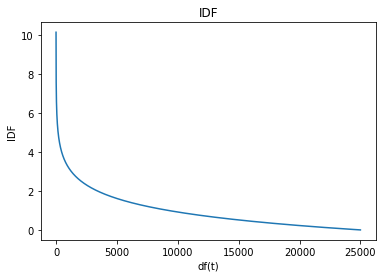

In [7]:
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

### ストップワード

In [8]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,best,ever,funny,i,movie,never,soooo,this,what
0,0,0,0,1,0,1,0,1,1,0
1,1,0,0,0,1,1,1,0,0,1
2,0,1,1,0,0,2,0,0,1,0


In [9]:
# はじめて使う場合はストップワードをダウンロード
import nltk
stop_words = nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sasanoshouta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,best,ever,movie,this
0,0,0,0,1,1
1,1,0,0,1,0
2,0,1,1,2,1


【問題2】TF-IDFの計算

In [11]:
vectorizer = CountVectorizer(stop_words=stop_words, max_features = 5000)
bow_train = (vectorizer.fit_transform(x_train)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
df

,00,000,10,100,11,12,13,13th,14,15,...,yet,york,young,younger,youth,zero,zizek,zombie,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,1,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
24996,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
24997,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tf1 = TfidfVectorizer(stop_words=stop_words, max_features=10000)
res = Tf1.fit_transform(x_train)

In [13]:
res.shape

(25000, 10000)

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

Tf2 = TfidfTransformer()
res2 = Tf2.fit_transform(df)
res2

<25000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1999647 stored elements in Compressed Sparse Row format>

In [15]:
res2.shape

(25000, 5000)

【問題3】TF-IDFを用いた学習

In [16]:
test = Tf1.transform(x_test)

In [18]:
test.shape

(25000, 10000)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

LR = LogisticRegression()
LR.fit(res, y_train)

pred = LR.predict(test)
pred

array([1, 0, 1, ..., 0, 0, 0])

In [20]:
# 最大特徴量：5000
print(f'正解率：{metrics.accuracy_score(pred, y_test)}')

正解率：0.88276


In [21]:
LR = LogisticRegression()
LR.fit(res, y_train)

pred = LR.predict(test)
pred

array([1, 0, 1, ..., 0, 0, 0])

In [22]:
# 最大特徴量：10000
print(f'正解率：{metrics.accuracy_score(pred, y_test)}')

正解率：0.88276


【問題4】TF-IDFのスクラッチ実装

In [23]:
mini_dataset = \
  ["This movie is SOOOO funny!!!",
  "What a movie! I never",
  "best movie ever!!!!! this movie"]

In [24]:
import numpy as np
import pandas as pd

def scratch_tfidf(text):
    split_words = [s.lower().replace('!', '').split(" ") for s in mini_dataset]
    unique_list = list(np.unique(np.array(split_words)))
    
    counter = 0
    count = 0
    result_df = pd.DataFrame(index=[], columns=unique_list)
    for s in range(len(split_words)):
        for k in unique_list:
            for l in split_words[s]:
                if k == l:
                    counter += 1
                else:
                    pass
            result_df.loc[s, k] = np.log((1 + len(split_words)) / (1 + counter)) + 1
            counter = 0
    return result_df

rs = scratch_tfidf(mini_dataset)
rs

,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,2.38629,2.38629,2.38629,1.69315,2.38629,1.69315,1.69315,2.38629,1.69315,1.69315,2.38629
1,1.69315,2.38629,2.38629,2.38629,1.69315,2.38629,1.69315,1.69315,2.38629,2.38629,1.69315
2,2.38629,1.69315,1.69315,2.38629,2.38629,2.38629,1.28768,2.38629,2.38629,1.69315,2.38629


### Word2Vec

BoWやTF-IDFはone-hot表現であったため、得られるベクトルの次元は語彙数分になります。そのため、語彙数を増やしにくいという問題があります。一方で、Word2Vecでは単語を任意の次元のベクトルに変換します。これをを Word Embedding（単語埋め込み） や 分散表現 と呼びます。変換操作を「ベクトル空間に埋め込む」と言うことが多いです。<br>

### CBoW

CBoW (Continuous Bag-of-Words) によるWord2Vecではある単語とある単語の間に来る単語を推定できるように全結合層2層のニューラルネットワークを学習します。<br>

単語はコーパスの語彙数次元のone-hot表現を行なっておきます。そのため、入力と出力の次元は語彙数と同じになります。一方で、中間のノード数をWord2Vecにより得たい任意の次元数とします。これにより全結合層の重みは「得たい次元のノード数×語彙数」になります。このネットワークにより学習を行なった後、出力側の重みを取り出すことで、各語彙を表すベクトルを手に入れることができます。<br>

間の単語の推定を行なっているため、同じ箇所で代替可能な言葉は似たベクトルになるというメリットもあります。これはBoWやTF-IDFでは得られない情報です。<br>

あるテキストは「そのテキストの長さ（単語数）×Word2Vecで得た分散表現の次元数」の配列になりますが、各入力の配列を揃える必要があるモデルに入力するためには、短いテキストは空白を表す単語を加える パディング を行なったり、長いテキストは単語を消したりします。テキストを 固定長 にすると呼びます。<br>

### ウィンドウサイズ
入力する単語は推定する前後1つずつだけでなく、複数個とする場合もあります。前後いくつを見るかの大きさを ウィンドウサイズ と呼びます。<br>

### Skip-gram
CBoWとは逆にある単語の前後の単語を推定できるように全結合層2層のニューラルネットワークを学習する方法が Skip-gram です。学習を行なった後は入力側の重みを取り出し各語彙を表すベクトルとします。現在一般的に使われているのはCBoWよりもSki-gramです。<br>



バージョンの関係で書き換え発生：
https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4<br>

In [19]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, vector_size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs) # 学習

print("語彙の一覧 : {}".format(model.wv.index_to_key))
for vocab in model.wv.index_to_key:
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : ['very', 'bad', 'good', 'is', 'this', 'a', 'film', 'movie']
veryのベクトル : 
[-0.00536227  0.0023643   0.0510335   0.09009273 -0.0930295  -0.07116809
  0.06458871  0.08972988 -0.05015428 -0.03763373]
badのベクトル : 
[ 0.07380505 -0.01533473 -0.04536615  0.06554051 -0.0486016  -0.01816018
  0.0287658   0.00991874 -0.08285215 -0.09448819]
goodのベクトル : 
[ 0.07311766  0.05070262  0.06757693  0.00762866  0.06350889 -0.03405366
 -0.00946403  0.05768573 -0.07521639 -0.03936105]
isのベクトル : 
[-0.07511629 -0.00930048  0.09538178 -0.07319212 -0.02333784 -0.01937754
  0.08077486 -0.05930933  0.00045162 -0.04753765]
thisのベクトル : 
[-0.0960355   0.05007293 -0.08759587 -0.04391825 -0.000351   -0.00296183
 -0.0766124   0.09614742  0.04982056  0.09233143]
aのベクトル : 
[-0.08157919  0.04495797 -0.04137077  0.00824535  0.08498619 -0.04462178
  0.045175   -0.06786962 -0.03548489  0.09398508]
filmのベクトル : 
[-0.01577674  0.00321376 -0.04140681 -0.07682785 -0.01508028  0.02469826
 -0.00888039  0.05533731 -0.02743011

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [20]:
model.wv.most_similar(positive="good", topn=3)

[('movie', 0.427315354347229),
 ('bad', 0.32937222719192505),
 ('very', 0.3004249632358551)]

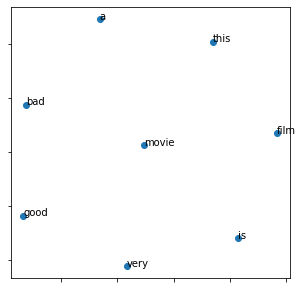

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocabs = model.wv.index_to_key
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model.wv[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

【問題5】コーパスの前処理

参考サイト：<br>
https://qiita.com/Hironsan/items/2466fe0f344115aff177<br>
https://github.com/Hironsan/natural-language-preprocessings/blob/master/preprocessings/ja/cleaning.py<br>

In [122]:
import re

def clean_text(text):
    replaced_text = '\n'.join(s.strip() for s in text.splitlines() if s != '')
#     replaced_text = '\n'.join(s.strip() for s in text.splitlines()[2:] if s != '')  # skip header by [2:]
    replaced_text = replaced_text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'<.*?>', ' ', replaced_text)       # <br>等の除去
    replaced_text = re.sub(r'[! : * '' "" ; # % & $]', ' ', replaced_text) # !, :, *, ', ", ;, #, %, &, $の除去
    replaced_text = re.sub(r'[<>]', ' ', replaced_text)       # <>の除去
    replaced_text = re.sub(r'[- ー]', ' ', replaced_text)       # ハイフンの除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = replaced_text.split(" ")
#     replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    return replaced_text

train_result = x_train.copy()
test_result = x_test.copy()
for i in range(len(x_train)):
    train_result[i] = clean_text(x_train[i])
    
for i in range(len(x_test)):
    test_result[i] = clean_text(x_test[i])

以下結果比較

In [123]:
x_train[20]

"This independent, B&W, DV feature consistently shocks, amazes and amuses with it's ability to create the most insane situations and then find humor and interest in them. It's all hilarious and ridiculous stuff, yet as absurd as much of the film should be, there is a heart and a reality here that keeps the film grounded, keeps the entire piece from drifting into complete craziness and therein lies the real message here. This film is about how we all survive in a world gone mad. That seems to be the heart of the film. For as insane and off the wall as things get, Leon, the 30 yr. old paperboy-protagonist, always tries to keep it together. He's like a child forever trying to catch the balloon that is floating away so that everything will work out for the best, so that everyone can have what they want.<br /><br />The acting in the film could have went far over the top but the exceptional cast really keeps the piece cohesive. Van Meter is perhaps the best of the bunch here with a performan

In [124]:
train_result[20]

['this',
 'independent,',
 'b',
 'w,',
 'dv',
 'feature',
 'consistently',
 'shocks,',
 'amazes',
 'and',
 'amuses',
 'with',
 "it's",
 'ability',
 'to',
 'create',
 'the',
 'most',
 'insane',
 'situations',
 'and',
 'then',
 'find',
 'humor',
 'and',
 'interest',
 'in',
 'them.',
 "it's",
 'all',
 'hilarious',
 'and',
 'ridiculous',
 'stuff,',
 'yet',
 'as',
 'absurd',
 'as',
 'much',
 'of',
 'the',
 'film',
 'should',
 'be,',
 'there',
 'is',
 'a',
 'heart',
 'and',
 'a',
 'reality',
 'here',
 'that',
 'keeps',
 'the',
 'film',
 'grounded,',
 'keeps',
 'the',
 'entire',
 'piece',
 'from',
 'drifting',
 'into',
 'complete',
 'craziness',
 'and',
 'therein',
 'lies',
 'the',
 'real',
 'message',
 'here.',
 'this',
 'film',
 'is',
 'about',
 'how',
 'we',
 'all',
 'survive',
 'in',
 'a',
 'world',
 'gone',
 'mad.',
 'that',
 'seems',
 'to',
 'be',
 'the',
 'heart',
 'of',
 'the',
 'film.',
 'for',
 'as',
 'insane',
 'and',
 'off',
 'the',
 'wall',
 'as',
 'things',
 'get,',
 'leon,',
 '

In [125]:
x_train[0]

"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [126]:
train_result[0]

['zero',
 'day',
 'leads',
 'you',
 'to',
 'think,',
 'even',
 're',
 'think',
 'why',
 'two',
 'boys/young',
 'men',
 'would',
 'do',
 'what',
 'they',
 'did',
 '',
 '',
 'commit',
 'mutual',
 'suicide',
 'via',
 'slaughtering',
 'their',
 'classmates.',
 'it',
 'captures',
 'what',
 'must',
 'be',
 'beyond',
 'a',
 'bizarre',
 'mode',
 'of',
 'being',
 'for',
 'two',
 'humans',
 'who',
 'have',
 'decided',
 'to',
 'withdraw',
 'from',
 'common',
 'civility',
 'in',
 'order',
 'to',
 'define',
 'their',
 'own/mutual',
 'world',
 'via',
 'coupled',
 'destruction.',
 '',
 'it',
 'is',
 'not',
 'a',
 'perfect',
 'movie',
 'but',
 'given',
 'what',
 'money/time',
 'the',
 'filmmaker',
 'and',
 'actors',
 'had',
 '',
 '',
 'it',
 'is',
 'a',
 'remarkable',
 'product.',
 'in',
 'terms',
 'of',
 'explaining',
 'the',
 'motives',
 'and',
 'actions',
 'of',
 'the',
 'two',
 'young',
 'suicide/murderers',
 'it',
 'is',
 'better',
 'than',
 "'elephant'",
 '',
 '',
 'in',
 'terms',
 'of',
 'being

【問題6】Word2Vecの学習

In [114]:
# ストップワード処理
vectorizer = CountVectorizer(stop_words=stop_words, max_features = 10000)
bow_train = (vectorizer.fit_transform(train_result)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,00,000,10,100,1000,101,11,12,13,13th,...,zizek,zodiac,zombi,zombie,zombies,zone,zoo,zoom,zorro,zu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
bow_train.shape

(25000, 10000)

In [128]:
from gensim.models import Word2Vec

model = Word2Vec(min_count=1, vector_size=10, max_vocab_size=100) # 次元数を10に設定
model.build_vocab(train_result) # 準備
model.train(train_result, total_examples=model.corpus_count, epochs=model.epochs) # 学習

print("語彙の一覧 : {}".format(model.wv.index_to_key))
for vocab in model.wv.index_to_key:
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : ['the', '', 'a', 'and', 'of', 'to', 'is', 'in', 'i', 'this', 'it', 'that', 'was', 'for', 'but', 'movie', 'film', 'are', 'you', 'have']
theのベクトル : 
[-0.846714   -0.07077787 -0.7450082  -0.6935251  -0.7526692  -1.6002014
 -1.6822009  -0.11454532  0.1661969   0.6187937 ]
のベクトル : 
[ 0.92013913 -0.8004001  -0.3972474   1.4916595  -2.8347616   0.10850889
 -2.31977     2.902274    0.13701983 -2.6773365 ]
aのベクトル : 
[-0.4638285   0.55605185 -0.21534187 -1.1367005  -0.341923   -0.75662136
 -1.3119172   0.5100618   0.4776484  -0.39996037]
andのベクトル : 
[-0.75681293  0.43218744 -0.5204774  -0.5264027  -0.90515214 -1.2573717
 -1.0346076  -0.22924013  0.82789576  0.30366343]
ofのベクトル : 
[-1.051761   -0.06267798 -0.37242207 -0.6982908  -1.147677   -1.0360973
 -1.3743628  -0.00675441  0.6721344   0.70799303]
toのベクトル : 
[-0.3642192   0.80128485  0.00297962 -0.69594854 -1.0251112  -0.7080041
 -0.8979521  -0.32604444  0.14391121  0.10659479]
isのベクトル : 
[-1.9395218e+00 -1.7316781e-04  3.6871415e-01 -

【問題7】（アドバンス課題）ベクトルの可視化

In [134]:
model.wv.most_similar(positive="film", topn=3)

[('of', 0.41254812479019165),
 ('the', 0.32658517360687256),
 ('in', 0.3043747544288635)]

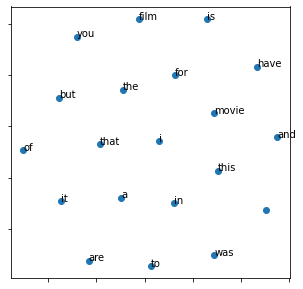

In [135]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocabs = model.wv.index_to_key
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model.wv[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

【問題8】（アドバンス課題）Word2Vecを用いた映画レビューの分類